# image_classification (hasRing problem) with CNN model

In [1]:
import os
from collections import Counter
import getpass

import matplotlib.pyplot as plt
import numpy as np
import json
import keras
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from Teemo.utils.models_utils import load_model_keras
from Teemo.algorithm.preprocessing import image

Using Theano backend.


## prepare data

In [12]:
def prepare_data(data_dir, color_mode, batch_size, flow_from_directory=True):
    print 'Build data generator ...'
    train_data_dir = data_dir + '/train'
    validation_data_dir = data_dir + '/validation'
    img_width, img_height = 100, 100

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1./255)

    if flow_from_directory:
        train_generator = train_datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                color_mode = color_mode,
                class_mode='binary')

        validation_generator = validation_datagen.flow_from_directory(
                validation_data_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                color_mode = color_mode,
                class_mode='binary')
    else:
        X_train, y_train = read_images(train_data_dir)
        X_validation, y_validation = read_images(validation_data_dir)

        train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
        validation_generator = validation_datagen.flow(X_validation, y_validation, batch_size=batch_size)
    print 'flow_from_directory: ', flow_from_directory
    return train_generator, validation_generator

def images_to_array(data_dir, grayscale=True, target_size=None, dim_ordering='default'):
    file_list = os.listdir(data_dir)
    X = []
    y = []
    for f in file_list:
        img = image.load_img(data_dir + f, grayscale, target_size)
        arr = image.img_to_array(img, dim_ordering)
        X.append(arr[np.newaxis, :])
        target = int(f.split('_')[0])
        y.append(target)

    return np.concatenate(X), np.asarray(y, dtype=np.float32)
        

def read_images(data_dir, grayscale=True, target_size=None, dim_ordering='default'):
    X_0, y_0 = images_to_array(data_dir+'/class_0/')
    X_1, y_1 = images_to_array(data_dir+'/class_1/')
    X = np.concatenate([X_0, X_1])
    y = np.concatenate([y_0, y_1])
    return X, y

## build model

In [24]:
from keras.optimizers import SGD, RMSprop

def build_model(color_mode):
    img_width, img_height = 100, 100
    dim_ordering = K.image_dim_ordering()

    if color_mode == 'grayscale':
        n_channel = 1
    elif color_mode == 'rgb':
        n_channel = 3

    if dim_ordering == 'tf':
        input_shape = (img_width, img_height, n_channel)
    elif dim_ordering == 'th':
        input_shape = (n_channel, img_width, img_height)

    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [25]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.records = []

    def on_epoch_end(self, epoch, logs={}):
        record_metrics = (logs.get('loss'), logs.get('acc'), 
                       logs.get('val_loss'), logs.get('val_acc'))
        self.records.append(record_metrics)

Build data generator ...
flow_from_directory:  False
dim_ordering:  th
Epoch 1/13
860/860 [==============================] - 23s - loss: 0.6652 - acc: 0.5442 - val_loss: 0.6628 - val_acc: 0.5260
Epoch 2/13
860/860 [==============================] - 23s - loss: 0.5438 - acc: 0.8093 - val_loss: 0.5614 - val_acc: 0.7318
Epoch 3/13
860/860 [==============================] - 23s - loss: 0.3818 - acc: 0.8895 - val_loss: 0.4686 - val_acc: 0.7786
Epoch 4/13
860/860 [==============================] - 23s - loss: 0.2856 - acc: 0.8988 - val_loss: 0.4188 - val_acc: 0.8073
Epoch 5/13
860/860 [==============================] - 23s - loss: 0.2376 - acc: 0.9209 - val_loss: 0.4064 - val_acc: 0.7995
Epoch 6/13
860/860 [==============================] - 23s - loss: 0.2287 - acc: 0.9128 - val_loss: 0.3782 - val_acc: 0.8125
Epoch 7/13
860/860 [==============================] - 23s - loss: 0.2244 - acc: 0.9198 - val_loss: 0.3728 - val_acc: 0.8203
Epoch 8/13
860/860 [==============================] - 21s - l

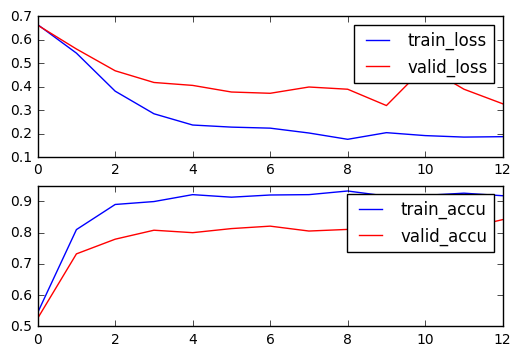

In [26]:
def train_model():
    model_dir = '/home/'+getpass.getuser()+'/git_test/test_data/models/'
    data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/hasRing/data/'
    color_mode = 'grayscale' # 'grayscale', 'rgb'
    batch_size = 16
    nb_train_samples = 860
    nb_validation_samples = 384
    nb_epoch = 13

    train_generator, validation_generator = prepare_data(data_dir, color_mode, batch_size, flow_from_directory=False)
    history = LossHistory()
    checkpointer = ModelCheckpoint(filepath=model_dir+'model_weights.hdf5', 
                                   verbose=1, save_best_only=True)

    print 'dim_ordering: ', K.image_dim_ordering()
    model = build_model(color_mode)
    config = model.to_json()
    json.dump(config, open(model_dir+'model_config.json', 'w'))

    model.fit_generator(
            train_generator,
            samples_per_epoch=nb_train_samples,
            nb_epoch=nb_epoch,
            validation_data = validation_generator,
            nb_val_samples=nb_validation_samples,
            callbacks=[history, checkpointer])

    train_loss = [x[0] for x in history.records]
    train_accu = [x[1] for x in history.records]
    valid_loss = [x[2] for x in history.records]
    valid_accu = [x[3] for x in history.records]
    plt.figure()
    plt.subplot(211)
    plt.plot(range(len(train_loss)), train_loss, c='b', label='train_loss')
    plt.plot(range(len(valid_loss)), valid_loss, c='r', label='valid_loss')
    plt.legend()
    plt.subplot(212)
    plt.plot(range(len(train_accu)), train_accu, c='b', label='train_accu')
    plt.plot(range(len(valid_accu)), valid_accu, c='r', label='valid_accu')
    plt.legend()

    # evaluate the checkpoint model
    model_2 = load_model_keras(model_dir+'model_config.json', model_dir+'model_weights.hdf5')
    model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

    evaluate = model_2.evaluate_generator(validation_generator, val_samples=nb_validation_samples)

    print model_2.metrics_names
    print evaluate

    plt.show()

train_model()

## display images

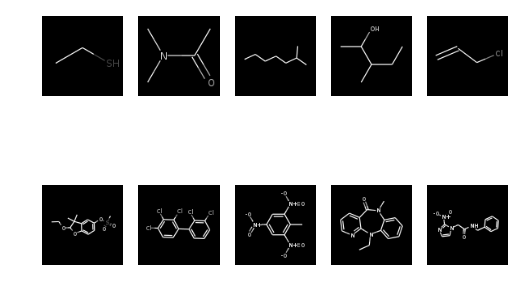

In [8]:
import os
import keras.backend as K
from Teemo.algorithm.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/hasRing/data/'
dir_class_0 = data_dir + 'train/class_0/'
dir_class_1 = data_dir + 'train/class_1/'
n_cols = 5
class_0_list = os.listdir(dir_class_0)[:n_cols]
class_1_list = os.listdir(dir_class_1)[:n_cols]

plt.figure()
for ii, f in enumerate(class_0_list):
    f = dir_class_0 + f
    img = Image.open(f)
    arr = image.img_to_array(img)[0, :, :]
    plt.subplot(2,n_cols,ii+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

for ii, f in enumerate(class_1_list):
    f = dir_class_1 + f
    img = Image.open(f)
    arr = image.img_to_array(img)[0, :, :]
    plt.subplot(2,n_cols,ii+n_cols+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.show()